<a href="https://colab.research.google.com/github/ismailkaya83/MY-DEEP-LEARNING-NOTEBOOKS/blob/master/Pretrained_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

There are two ways to use a pretrained network: **feature extraction** and **fine-tuning**. We’ll cover both of them. Let’s start with feature extraction.

## **Feature extraction**

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

In this case, because the ImageNet class set contains multiple dog and cat classes, it’s likely to be beneficial to reuse the information contained in the densely connected layers of the original model. But we’ll choose not to, in order to cover the more general case where the class set of the new problem doesn’t overlap the class set of the original model. Let’s put this in practice by using the convolutional base of the VGG16 network, trained on ImageNet, to extract interesting features from cat and dog images, and then train a dogs-versus-cats classifier on top of these features.

In [2]:
#Instantiating the VGG16 convolutional base

from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', #specifies the weight checkpoint from which to initialize the model.
                  include_top=False, #refers to including (or not) the densely connected classifier on top of the network. By default, this densely connected classifier corresponds to the 1,000 classes from ImageNet. Because you intend to use your own densely connected classifier (with only two classes: cat and dog), you don’t need to include it.
                  input_shape=(150, 150, 3)) #is the shape of the image tensors that you’ll feed to the network. This argument is purely optional: if you don’t pass it, the network will be able to process inputs of any size.

58892288/58889256 [==============================] - 0s 0us/step


In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

The final feature map has shape (4, 4, 512). That’s the feature on top of which you’ll stick a densely connected classifier.

At this point, there are two ways you could proceed:

- Running the convolutional base over your dataset, recording its output to a Numpy array on disk, and then using this data as input to a standalone, densely connected classifier similar to those you saw in part 1 of this book. This solution is fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. But for the same reason, this technique won’t allow you to use data augmentation.
- Extending the model you have (conv_base) by adding Dense layers on top, and running the whole thing end to end on the input data. This will allow you to use data augmentation, because every input image goes through the convolutional base every time it’s seen by the model. But for the same reason, this technique is far more expensive than the first.

**Fast feature extraction without data augmentation**

You’ll start by running instances of the previously introduced ImageDataGenerator to extract images as Numpy arrays as well as their labels. You’ll extract features from these images by calling the predict method of the conv_base model.

In [4]:
#Extracting features using the pretrained convolutional base

import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [5]:
base_dir = '/content/drive/MyDrive/Colab_Notebooks/cats_and_dogs_small'
train_dir = '/content/drive/MyDrive/Colab_Notebooks/cats_and_dogs_small/train'
validation_dir = '/content/drive/MyDrive/Colab_Notebooks/cats_and_dogs_small/validation'
test_dir = '/content/drive/MyDrive/Colab_Notebooks/cats_and_dogs_small/test'

In [6]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [7]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break #note that because generators yield data indefinitely in a loop, you must break after every image has been seen one
    return features, labels

In [8]:
train_features, train_labels = extract_features(train_dir, 2000)

Found 2000 images belonging to 2 classes.


In [9]:
test_features, test_labels = extract_features(test_dir, 1000)

Found 1000 images belonging to 2 classes.


In [10]:
validation_features, validation_labels = extract_features(validation_dir, 1000)

Found 1000 images belonging to 2 classes.


The extracted features are currently of shape (samples, 4, 4, 512). You’ll feed them to a densely connected classifier, so first you must flatten them to (samples, 8192):

In [11]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

At this point, you can define your densely connected classifier (note the use of dropout for regularization) and train it on the data and labels that you just recorded.

In [12]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 1s 5ms/step - loss: 0.6124 - acc: 0.6585 - val_loss: 0.4462 - val_acc: 0.8460
Epoch 2/30
100/100 [==============================] - 0s 4ms/step - loss: 0.4373 - acc: 0.8040 - val_loss: 0.3607 - val_acc: 0.8660
Epoch 3/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3611 - acc: 0.8420 - val_loss: 0.3177 - val_acc: 0.8830
Epoch 4/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3160 - acc: 0.8665 - val_loss: 0.2997 - val_acc: 0.8870
Epoch 5/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2778 - acc: 0.8920 - val_loss: 0.2787 - val_acc: 0.8930
Epoch 6/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2622 - acc: 0.8895 - val_loss: 0.2689 - val_acc: 0.8950
Epoch 7/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2416 - acc: 0.9060 - val_loss: 0.2672 - val_acc: 0.8900
Epoch 8/30
100/100 [==============================] - 0s 4ms/step - loss: 0.

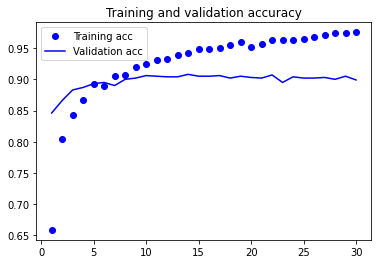

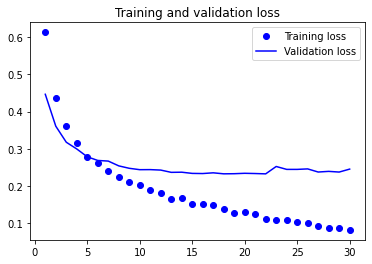

In [13]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

We reach a validation accuracy of about 90%—much better than you achieved in the previous section with the small model trained from scratch. But the plots also indicate that we’re overfitting almost from the start—despite using dropout with a fairly large rate. That’s because this technique doesn’t use data augmentation, which is essential for preventing overfitting with small image datasets.

**Feature extraction with data augmentation**

Now, let’s review the second technique I mentioned for doing feature extraction, which is much slower and more expensive, but which allows you to use data augmentation during training: extending the conv_base model and running it end to end on the inputs.

In [14]:
#Adding a densely connected classifier on top of the convolutional base

from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


Before you compile and train the model, it’s very important to freeze the convolutional base. Freezing a layer or set of layers means preventing their weights from being updated during training. If you don’t do this, then the representations that were previously learned by the convolutional base will be modified during training. Because the Dense layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In Keras, you freeze a network by setting its trainable attribute to False:



In [16]:
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


With this setup, only the weights from the two Dense layers that you added will be trained. That’s a total of four weight tensors: two per layer (the main weight matrix and the bias vector). Note that in order for these changes to take effect, you must first compile the model. If you ever modify weight trainability after compilation, you should then recompile the model, or these changes will be ignored.

In [17]:
#Training the model end to end with a frozen convolutional base

from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 24s 242ms/step - loss: 0.5895 - acc: 0.7020 - val_loss: 0.4530 - val_acc: 0.8220
Epoch 2/30
100/100 [==============================] - 24s 237ms/step - loss: 0.4930 - acc: 0.7845 - val_loss: 0.3820 - val_acc: 0.8440
Epoch 3/30
100/100 [==============================] - 23s 233ms/step - loss: 0.4474 - acc: 0.7980 - val_loss: 0.3330 - val_acc: 0.8780
Epoch 4/30
100/100 [==============================] - 24s 236ms/step - loss: 0.4071 - acc: 0.8180 - val_loss: 0.3158 - val_acc: 0.8660
Epoch 5/30
100/100 [==============================] - 23s 232ms/step - loss: 0.3901 - acc: 0.8205 - val_loss: 0.3056 - val_acc: 0.8820
Epoch 6/30
100/100 [==============================] - 23s 233ms/step - loss: 0.3677 - acc: 0.8470 - val_loss: 0.2830 - val_acc: 0.8880
Epoch 7/30
100/100 [==============================] - 24s 240ms/step - loss: 0.3560 - acc: 0.8530 - val_lo

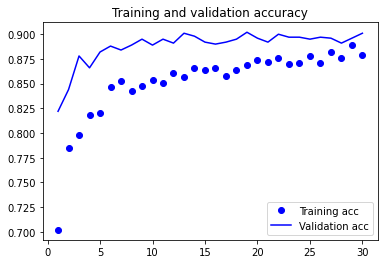

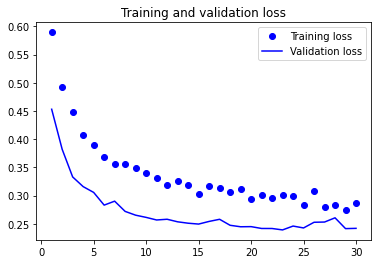

In [19]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## **Fine-tuning**

Another widely used technique for model reuse, complementary to feature extraction, is fine-tuning. Fine-tuning consists of unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in this case, the fully connected classifier) and these top layers. This is called fine-tuning because it slightly adjusts the more abstract representations of the model being reused, in order to make them more relevant for the problem at hand.

It’s necessary to freeze the convolution base of VGG16 in order to be able to train a randomly initialized classifier on top. For the same reason, it’s only possible to fine-tune the top layers of the convolutional base once the classifier on top has already been trained. If the classifier isn’t already trained, then the error signal propagating through the network during training will be too large, and the representations previously learned by the layers being fine-tuned will be destroyed. Thus the steps for fine-tuning a network are as follow:

- Add your custom network on top of an already-trained base network.
- Freeze the base network.
- Train the part you added.
- Unfreeze some layers in the base network.
- Jointly train both these layers and the part you added.

You already completed the first three steps when doing feature extraction. Let’s proceed with step 4: you’ll unfreeze your conv_base and then freeze individual layers inside it.

In [20]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

You’ll fine-tune the last three convolutional layers, which means all layers up to block4_pool should be frozen, and the layers block5_conv1, block5_conv2, and block5_conv3 should be trainable.

Why not fine-tune more layers? Why not fine-tune the entire convolutional base? You could. But you need to consider the following:

- Earlier layers in the convolutional base encode more-generic, reusable features, whereas layers higher up encode more-specialized features. It’s more useful to fine-tune the more specialized features, because these are the ones that need to be repurposed on your new problem. There would be fast-decreasing returns in fine-tuning lower layers.
- The more parameters you’re training, the more you’re at risk of overfitting. The convolutional base has 15 million parameters, so it would be risky to attempt to train it on your small dataset.

Thus, in this situation, it’s a good strategy to fine-tune only the top two or three layers in the convolutional base. Let’s set this up, starting from where you left off in the previous example.

In [21]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Now you can begin fine-tuning the network. You’ll do this with the RMSProp optimizer, using a very low learning rate. The reason for using a low learning rate is that you want to limit the magnitude of the modifications you make to the representations of the three layers you’re fine-tuning. Updates that are too large may harm these representations.

In [22]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 24s 239ms/step - loss: 0.2922 - acc: 0.8800 - val_loss: 0.2239 - val_acc: 0.9110
Epoch 2/100
100/100 [==============================] - 24s 236ms/step - loss: 0.2713 - acc: 0.8835 - val_loss: 0.2089 - val_acc: 0.9180
Epoch 3/100
100/100 [==============================] - 24s 237ms/step - loss: 0.2408 - acc: 0.8970 - val_loss: 0.2106 - val_acc: 0.9170
Epoch 4/100
100/100 [==============================] - 24s 245ms/step - loss: 0.2063 - acc: 0.9115 - val_loss: 0.2121 - val_acc: 0.9150
Epoch 5/100
100/100 [==============================] - 23s 234ms/step - loss: 0.1994 - acc: 0.9140 - val_loss: 0.1961 - val_acc: 0.9220
Epoch 6/100
100/100 [==============================] - 23s 232ms/step - loss: 0.1972 - acc: 0.9170 - val_loss: 0.1977 - val_acc: 0.9290
Epoch 7/100
100/100 [==============================] - 23s 232ms/step - loss: 0.1864 - acc: 0.9260 - val_loss: 0.1912 - val_acc: 0.9270
Epoch 8/100
100/100 [===========================

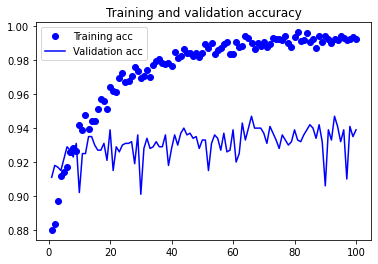

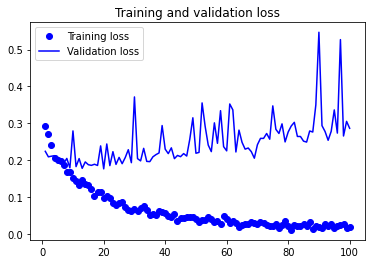

In [23]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

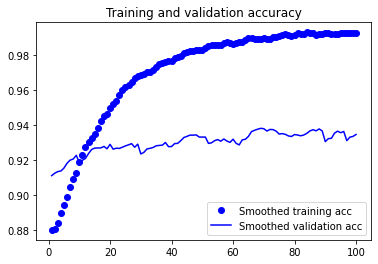

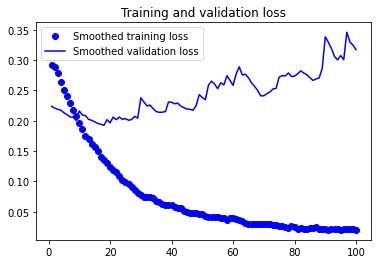

In [24]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The validation accuracy curve look much cleaner. You’re seeing a nice 1% absolute improvement in accuracy, from about 96% to above 97%.

Note that the loss curve doesn’t show any real improvement (in fact, it’s deteriorating). You may wonder, how could accuracy stay stable or improve if the loss isn’t decreasing? The answer is simple: what you display is an average of pointwise loss values; but what matters for accuracy is the distribution of the loss values, not their average, because accuracy is the result of a binary thresholding of the class probability predicted by the model. The model may still be improving even if this isn’t reflected in the average loss.

You can now finally evaluate this model on the test data:

In [26]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 4s 83ms/step - loss: 0.3656 - acc: 0.9350
test acc: 0.9350000023841858
